В этом ноутбуке берется переписанный код статьи и проверяется корректность его запуска, а именно, что итоговые метрики будут похожи на предоставленные в статье.

In [1]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm.tabddpm import *

### Подготовка

In [3]:
model_name = 'tabddpm'
dataname = 'shoppers'
model_short = 'TabDDPM'
save_cat = None

In [4]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)
CONFIG.add_arg('save_cat', save_cat)

In [5]:
download_dataset(dataname)
process_data(dataname)

Start processing dataset shoppers from UCI.
Aready downloaded.
n_clusters: 25
shoppers (11097, 18) (1233, 18) (12330, 18)


/workspace/TabDDPM_copy/TabDDPM/utils.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns = idx_name_mapping, inplace=True)
/workspace/TabDDPM_copy/TabDDPM/utils.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns = idx_name_mapping, inplace=True)
/workspace/TabDDPM_copy/TabDDPM/utils.py:379: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df[col] == '?', col] = 'nan'
/workspace

Numerical (11097, 10)
Categorical (11097, 7)
Processing and Saving shoppers Successfully!
shoppers
Total 12330
Train 11097
Test 1233
Num 10
Cat 8


In [6]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('sample_save_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('real_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/real.csv")
CONFIG.add_arg('test_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/test.csv")
CONFIG.add_arg('info_path',
               f"data/{CONFIG.get_arg('dataname')}/info.json")

Device: cuda


In [7]:
CONFIG.get_all_args()

{'dataname': 'shoppers',
 'method': 'tabddpm',
 'device': 'cuda',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/shoppers/tabddpm.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 1,
 'real_path': 'synthetic/shoppers/real.csv',
 'test_path': 'synthetic/shoppers/test.csv',
 'info_path': 'data/shoppers/info.json',
 'save_path': './synthetic/magic_ON_QnSC_200k/initial_tabddpm_ON_QnSC_200k_mult_9.csv',
 'num_clusters': 25,
 'save_cat': None}

### Train

In [8]:
CONFIG.add_arg('mode', 'train')

In [9]:
tabddpm = TabDDPM(CONFIG)

In [11]:
tabddpm.train()

In [12]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
cmap = get_cmap(10)

/tmp/ipykernel_90313/2983808042.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


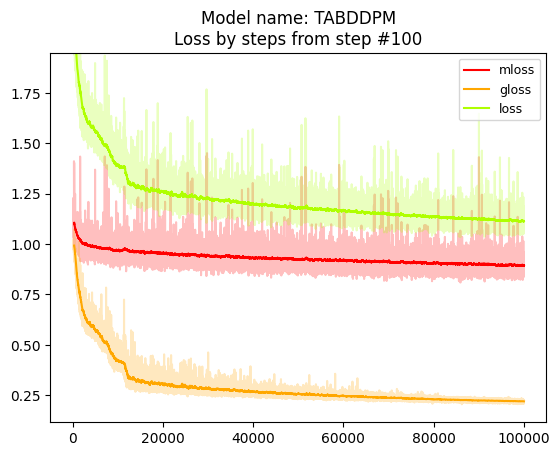

In [13]:
loss = pd.read_csv(f'./models/{model_name}/ckpt/{dataname}/loss.csv')
max_v, min_v = -np.inf, np.inf
window = 250

start_step = 100
for i, l in enumerate(loss.columns[1:]):
    plt.plot(loss['step'][start_step:], loss[l][start_step:], alpha=0.25, color=cmap(i))
    smoothed = np.convolve(loss[l][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=l, color=cmap(i))

    max_v = np.max([np.quantile(loss[l][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss[l][start_step:], 0.01), min_v])

plt.ylim([min_v-0.1, max_v+0.1]) 
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}")
plt.savefig(f'./models/{model_name}/ckpt/{dataname}/loss_image.png')
plt.show()

In [14]:
tabddpm.sample(sample_save_path=CONFIG.get_arg('sample_save_path'))

No NaNs in numerical features, skipping
mlp
torch.Size([10000, 67])
Sample timestep    0
torch.Size([10000, 67])
Sample timestep    0
Shape torch.Size([11097, 18])
(11097, 8)
Sampling time: 105.27497601509094


### Расчет метрик

In [15]:
from eval.base_metrics import calculate_base_metrics
from eval.similarity import calculate_similarity
from eval.mle import calculate_mle
from eval.alpha_beta import calculate_alpha_beta
from eval.detection import calculate_detection
from eval.dcr import calculate_DCR

In [16]:
overall_metrics = {}
overall_metrics[model_name] = {}

#### Метрики из starter_kit

In [17]:
overall_metrics[model_name]['base_metrics'] = calculate_base_metrics(make_binary=False)

/venv/main/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TABDDPM: SHOPPERS Dataset
Original Logistic: 0.680
Synthetic Logistic: 0.620
Original Tree: 0.635
Synthetic Tree: 0.590 

TABDDPM Accuracy Loss: SHOPPERS
Logistic: 8.819%
Tree: 7.205% 



#### Метрики из статьи TabSyn

In [18]:
overall_metrics[model_name]['similarity'] = calculate_similarity()

CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:00<00:00, 149.69it/s]|
Column Shapes Score: 97.41%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:01<00:00, 130.41it/s]|
Column Pair Trends Score: 92.93%

Overall Score (Average): 95.17%

Error rate (%) of column-wise density estimation TABDDPM: 2.588 ± 1.479
Error rate (%) of pair-wise column correlation score TABDDPM: 7.070 ± 6.710


DONE! 

DRAW COLUMN VALUES DISTRIBUTIONS...


DONE!


#### MLE

In [19]:
overall_metrics[model_name]['mle'] = calculate_mle()

100%|██████████| 36/36 [00:07<00:00,  5.12it/s]


Saving scores to  eval/mle/shoppers/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.931 ± 0.003


#### Detection: classifier two sample tests (C2ST)

In [20]:
overall_metrics[model_name]['detection'] = calculate_detection()

shoppers, tabddpm: 0.8727481711993209


#### DCR

In [21]:
overall_metrics[model_name]['DCR'] = calculate_DCR()

n_clusters: 25
DCR Score, a value closer to 0.5 is better
shoppers-tabddpm, DCR Score = 0.5244660719113274


#### Alpha precision & Beta recall

In [22]:
overall_metrics[model_name]['quality'] = calculate_alpha_beta()

=========== All Features ===========
Data shape:  (11097, 77)
alpha precision: 0.918250, beta recall: 0.537797


### Табличка

In [23]:
final_metrics_table = []
for m in overall_metrics.keys():
    # Сбор таблички результатов
    tmp = pd.DataFrame([{'Model':'TabDDPM', 'Type':m, 'Data':dataname}])
    tmp.columns = pd.MultiIndex.from_tuples([('', i) for i in tmp.columns])
    result = [tmp]
    
    for metric_group in overall_metrics[m].keys():
        tmp = pd.DataFrame([overall_metrics[m][metric_group]])
        tmp.columns = pd.MultiIndex.from_tuples([(metric_group, i) for i in tmp.columns])
        result.append(tmp)
    result = pd.concat(result, axis = 1)
    final_metrics_table.append(result)
    
final_metrics_table = pd.concat(final_metrics_table)

In [24]:
pd.set_option('display.max_columns', None)
final_metrics_table.round(4)

base_metrics                     \
     Model     Type      Data Original Logistic Synthetic Logistic   
0  TabDDPM  tabddpm  shoppers            0.6803             0.6203   

                                                          \
  Original Tree Synthetic Tree Accuracy Loss Logistic, %   
0        0.6353         0.5896                    8.8191   

                                    similarity                              \
  Accuracy Loss Tree, % Column Shapes Score, % Column Pair Trends Score, %   
0                7.2051                97.4117                     92.9299   

                              \
  Overall Score (Average), %   
0                    95.1708   

                                                       \
  Error rate (%) of column-wise density estimation, %   
0                                              2.5883   

                                                           \
  Error rate (%) of column-wise density estimation std, %   
0                                                  1.4787   

                                                           \
  Error rate (%) of pair-wise column correlation score, %   
0                                                  7.0701   

                                                               \
  Error rate (%) of pair-wise column correlation score std, %   
0                                                      6.7101   

                                         mle  \
  ROC - AUC обучения на синтетических данных   
0                                     0.9306   

                                                  detection     DCR  \
  ROC - AUC обучения на синтетических данных, std     Score   Score   
0                                          0.0031    0.8727  0.5245   

          quality              
  alpha precision beta recall  
0          0.9183      0.5378

In [25]:
import os
if not os.path.exists(f'./eval/total/{dataname}'):
    os.makedirs(f'./eval/total/{dataname}')
final_metrics_table.to_csv(f'./eval/total/{dataname}/{model_short}_final_metrics_table.csv', index=False)